Baseline implementations
===

> This notebook introduces a few loss and metric functions. Afterwards, eight models based on four papers are re-implemented in `pytorch`. For each model, a `PPModel` is created.

In [ ]:
#| default_exp prediction.models

In [ ]:
#| hide


%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

%matplotlib inline

In [ ]:
#| hide
from nbdev.showdoc import *

# a flag, that controls if the training process is executed
_RUN_TRAINING=True

In [ ]:
#| export
from fastai.basics import *
from pympp.process import *
from pympp.prediction.predict import *
from math import sqrt

## Loss and Metrics

This section defines some metrics and loss functions. Apart from that, we use the standart loss functions and metrics from fastai and pytorch, namely accuracy, mae, and cross_entropy

In [ ]:
#| export
def maeDurDaysNormalize(p,yb,mean=0,std=0,unit=60*60*24):
    """
    Decodes time and converts from seconds to days
    Returns mae
    """
    p=p*std+mean
    yb=yb*std+mean
    return mae(p,yb)/(unit)

In [ ]:
#| export
def maeDurDaysMinMax(p,yb,minn=0,maxx=0,unit=60*60*24):
    """
    Decodes time and converts from seconds to days
    Returns mae
    """

    p=p*(maxx-minn) + minn
    yb=yb*(maxx-minn) + minn
    return mae(p,yb)/(unit)

In [ ]:
#| export
def _accuracy_idx(a,b,i): return accuracy(listify(a)[i],listify(b)[i])

In [ ]:
#| export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func, name):  
        self.func = func
        self.metricName = name
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self): return self.metricName
   

In [ ]:
def accuracy(inp, targ, axis=-1):
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [ ]:
#| export
def get_metrics(o,date_col='timestamp_Relative_elapsed'):
    'A utility function that automatically selects the correct metric functions based on the PPObj o'
    number_cats=len(o.ycat_names)

    accuracies=[]
    for i in range(number_cats):
        accuracy_func=partial(_accuracy_idx,i=i)
        accuracy_func=AvgMetric(accuracy_func,f"acc_{o.ycat_names[i]}")
        accuracies.append(accuracy_func)
    mae_days=None
    if len(o.ycont_names)>0:
        if 'minmax' in o.ycont_names[0]: # Here we expect only one timestamp
            minn,maxx = (o.procs.min_max.mins[date_col],
                         o.procs.min_max.maxs[date_col])
            mae_days=lambda p,y: maeDurDaysMinMax(listify(p)[-1],listify(y)[-1],minn=minn,maxx=maxx)
        else:
            mean,std=(o.procs.normalize.means[date_col],
                      o.procs.normalize.stds[date_col])
            mae_days=lambda p,y: maeDurDaysNormalize(listify(p)[-1],listify(y)[-1],mean=mean,std=std)
        mae_days.__name__='mae_days'
    return L(accuracies)+mae_days

In [ ]:
#| export
def multi_loss_sum(o,p,y):
    '''Multi Loss function that sums up multiple loss functions. 
    The selection of the loss function is based on the PPObj o'''
    p,y=listify(p),listify(y)
    len_cat,len_cont=len(o.ycat_names),len(o.ycont_names)
    cross_entropies=[F.cross_entropy(p[i],y[i]) for i in range(len_cat)]
    maes=[mae(p[i],y[i]) for i in range(len_cat,len_cat+len_cont)]
    return torch.sum(torch.stack(list(L(cross_entropies)+L(maes))))

## Camargo


**Input**: activity, resource, duration  
**Output**: activity, resource, duration  
**Loss**: sum(cross_entropy(activity),cross_entropy(resource),mae(duration))

In [ ]:
path= '../data/logs/csv/mppn_ds/Helpdesk.csv'

In [ ]:
log=import_log(path)
o=PPObj(log,[Categorify,Datetify,Normalize()],date_names=['timestamp'],cat_names=['activity','resource'],
    y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log))
o
dls=o.get_dls()

In [ ]:
xcat,xcont,y=dls.one_batch()

In [ ]:
xcat.shape,xcont.shape,len(y)

(torch.Size([64, 2, 5]), torch.Size([64, 1, 5]), 3)

### Spezialized


In [ ]:
#| export
class Camargo_specialized(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)
        self.lstm_res = nn.LSTM(emb_dim_res, hidden, batch_first=True, num_layers=2)
        self.lstm_tim = nn.LSTM(1, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont.transpose(1,2)
        x_act = self.emb_act(x_act)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)
        
        x_res = self.emb_res(x_res)
        x_res,_ = self.lstm_res(x_res)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)
        x_tim,_ = self.lstm_tim(x_tim)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

In [ ]:
m=Camargo_specialized(o)

In [ ]:
p=m(xcat.cpu(),xcont.cpu())

In [ ]:
loss=partial(multi_loss_sum,o)

In [ ]:
accuracy??

In [ ]:
loss(p,tuple(i.cpu()for i in y))

TensorBase(6.8803, grad_fn=<AliasBackward>)

In [ ]:
%%time
if _RUN_TRAINING:
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,print_output=True,show_plot=False)

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,5.087773,5.077742,0.845785,0.501916,5.414929,00:06


Better model found at epoch 0 with valid_loss value: 5.077742099761963.


Better model found at epoch 0 with valid_loss value: 0.8500967025756836.
CPU times: user 14.4 s, sys: 4.45 s, total: 18.9 s
Wall time: 19.6 s


### Concat

In [ ]:
#| export
class Camargo_concat(torch.nn.Module) :
    def __init__(self, o ) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_concat= nn.LSTM(emb_dim_act+emb_dim_res, hidden, batch_first=True, num_layers=1)
        self.lstm_act = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_res = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_tim = nn.LSTM(1, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont.transpose(1,2)
        x_act = self.emb_act(x_act)

        x_res = self.emb_res(x_res)
        x_concat=torch.cat((x_act, x_res), 2)
        x_concat,_=self.lstm_concat(x_concat)

        x_act,_ = self.lstm_act(x_concat)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        x_res,_ = self.lstm_res(x_concat)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)

        x_tim,_ = self.lstm_tim(x_tim)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

In [ ]:
%%time
if _RUN_TRAINING:

    log=import_log(path)
    o=PPObj(log,[Categorify,Datetify,Normalize()],date_names=['timestamp'],cat_names=['activity','resource'],
        y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log),)
    dls=o.get_dls()
    m=Camargo_concat(o)
    loss=0
    loss=partial(multi_loss_sum,o)
    train_validate(dls,m,loss=loss,metrics=get_metrics(o),epoch=1,print_output=True,show_plot=False,output_index=[1,2,3])

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,5.043581,5.004405,0.862868,0.521487,5.494439,00:06


Better model found at epoch 0 with valid_loss value: 5.0044050216674805.


Better model found at epoch 0 with valid_loss value: 0.8609335422515869.
CPU times: user 13.6 s, sys: 4.56 s, total: 18.1 s
Wall time: 18.7 s


### Full_Concat 


In [ ]:
#| export
class Camargo_fullconcat(torch.nn.Module) :


    def __init__(self, o  ) :
        super().__init__()

        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        vocab_res=len(o.procs.categorify['resource'])
        emb_dim_act = int(sqrt(vocab_act))+1
        emb_dim_res = int(sqrt(vocab_res))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        self.emb_res = nn.Embedding(vocab_res,emb_dim_res)

        self.lstm_concat= nn.LSTM(emb_dim_act+emb_dim_res+1, hidden, batch_first=True, num_layers=1)
        self.lstm_act = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_res = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)
        self.lstm_tim = nn.LSTM(hidden, hidden, batch_first=True, num_layers=1)

        self.linear_act = nn.Linear(hidden, vocab_act)
        self.linear_res = nn.Linear(hidden, vocab_res)
        self.linear_tim = nn.Linear(hidden, 1)
    def forward(self, xcat,xcont):
        x_act,x_res,x_tim=xcat[:,0],xcat[:,1],xcont.transpose(1,2)
        x_act = self.emb_act(x_act)

        x_res = self.emb_res(x_res)
        x_concat=torch.cat((x_act, x_res,x_tim), 2)
        x_concat,_=self.lstm_concat(x_concat)

        x_act,_ = self.lstm_act(x_concat)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        x_res,_ = self.lstm_res(x_concat)
        x_res = x_res[:,-1]
        x_res = self.linear_res(x_res)
        x_res = F.softmax(x_res,dim=1)

        x_tim,_ = self.lstm_tim(x_concat)
        x_tim = x_tim[:,-1]
        x_tim = self.linear_tim(x_tim)
        return x_act,x_res,x_tim

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,4.997516,4.959108,0.854572,0.517996,3.629107,00:05


Better model found at epoch 0 with valid_loss value: 4.959108352661133.


Better model found at epoch 0 with valid_loss value: 0.8306697010993958.
CPU times: user 12.6 s, sys: 4.56 s, total: 17.1 s
Wall time: 17.6 s


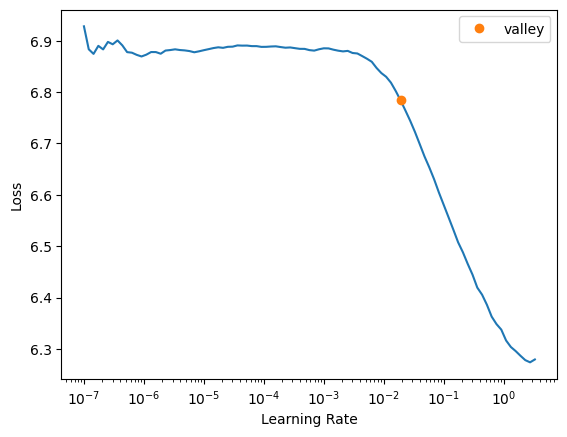

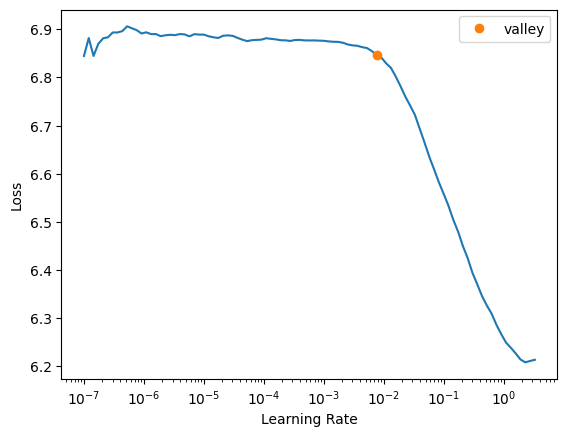

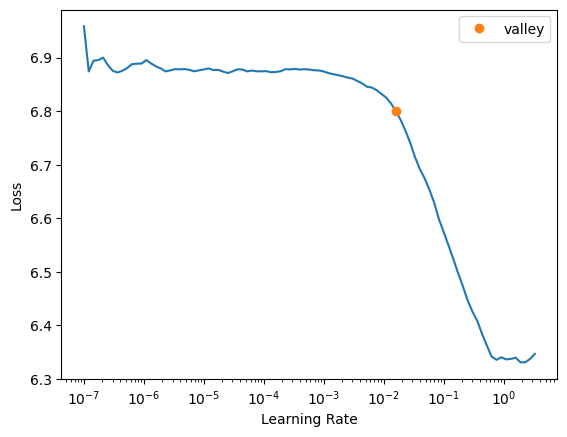

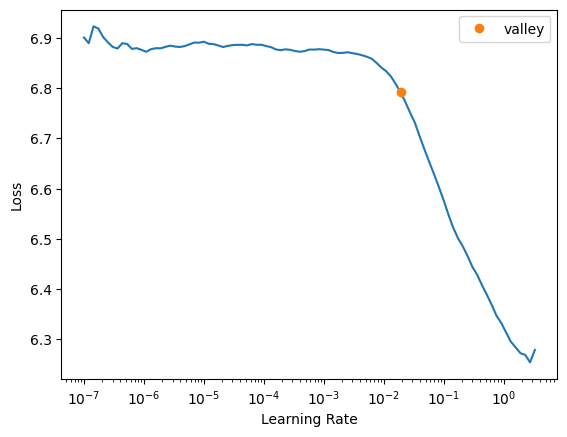

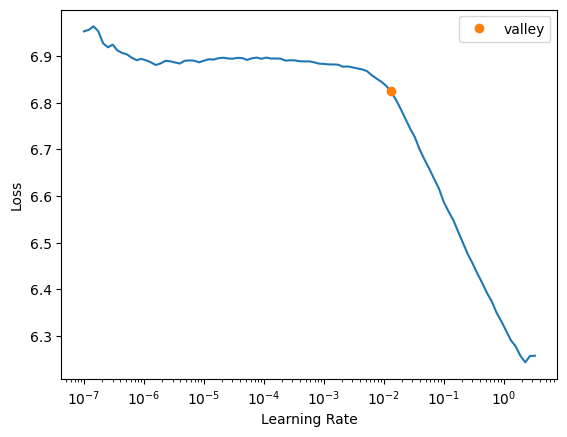

In [ ]:
%%time
if  _RUN_TRAINING:
    log=import_log(path)
    o=PPObj(log,[Categorify,Datetify,Normalize],date_names=['timestamp'],cat_names=['activity','resource'],
        y_names=['activity','resource','timestamp_Relative_elapsed'],splits=split_traces(log),)
    dls=o.get_dls()
    m=Camargo_fullconcat(o)
    loss=0
    loss=partial(multi_loss_sum,o)
    train_validate(dls,m,loss=loss,metrics=get_metrics(o),epoch=1,print_output=True,output_index=[1,2,3])

### PPMS


In [ ]:
#| export
class PPM_Camargo_Spezialized(PPModel):

    model = Camargo_specialized
    date_names=['timestamp']
    cat_names=['activity','resource']
    y_names=['activity','resource','timestamp_Relative_elapsed']
    cont_names=None
    procs=[Categorify,Datetify,Normalize,FillMissing]

    def setup(self):
        o=PPObj(self.log,self.procs,cat_names=self.cat_names,date_names=self.date_names,y_names=self.y_names,
                cont_names=self.cont_names,splits=self.splits)

        loss=partial(multi_loss_sum,o)

        # Next event prediction training
        print('Next event prediction training')
        dls=o.get_dls(bs=self.bs)
        m=self.model(o)
        self.nsp,self.nrp,self.dtnp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                   output_index=[1,2,3])


        # Last event prediction training
        print('Last event prediction training')
        dls=o.get_dls(outcome=True,bs=self.bs)
        m=self.model(o)
        self.op,self.lrp,self.dtlp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                 output_index=[1,2,3])



    def next_step_prediction(self): return self.nsp

    def next_resource_prediction(self):return self.nrp

    def last_resource_prediction(self): return self.lrp
    def outcome_prediction(self): return self.op
    def duration_to_next_event_prediction(self): return self.dtnp
    def duration_to_end_prediction(self): return self.dtlp
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [ ]:
#| export
class PPM_Camargo_concat(PPM_Camargo_Spezialized):
    model = Camargo_concat

class PPM_Camargo_fullconcat(PPM_Camargo_Spezialized):
    model = Camargo_fullconcat

In [ ]:
%%time
if _RUN_TRAINING:
    log=import_log(path)
    ppm=PPM_Camargo_fullconcat(log,get_ds_name(path),print_output=True,epoch=1,bs=512,
                               splits=split_traces(log))
    ppm.evaluate()

Helpdesk Camargo_fullconcat
Next event prediction training


epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,6.144738,5.782821,0.373098,0.366716,7.118637,00:01


Better model found at epoch 0 with valid_loss value: 5.782820701599121.


Better model found at epoch 0 with valid_loss value: 0.37526652216911316.
Last event prediction training


epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,5.491952,4.761328,1.000000,0.786942,7.440363,00:01


Better model found at epoch 0 with valid_loss value: 4.761327743530273.


Better model found at epoch 0 with valid_loss value: 1.0.
next_step_prediction
next_resource_prediction
last_resource_prediction
outcome_prediction
duration_to_next_event_prediction
duration_to_end_prediction
activity_suffix_prediction
resource_suffix_prediction
CPU times: user 18.4 s, sys: 19.9 s, total: 38.2 s
Wall time: 40.7 s


## Evermann

**Input**:  activity or resource  
**Output**: activity or resource  
**Loss**: cross_entropy(activity) or cross_entropy(resource)

In [ ]:
#| export

class Evermann(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        emb_dim = 5


        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x.squeeze())
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1])
        return F.softmax(x,dim=1)

In [ ]:
col='activity'
o=PPObj(log,procs=[Categorify],cat_names=col,y_names=col,splits=split_traces(log))
dls=o.get_dls()
xb,yb=dls.one_batch()

In [ ]:
m=Evermann(o)

In [ ]:
pb=m(xb.cpu())
F.cross_entropy(pb,yb[0].cpu()),accuracy(pb,yb[0].cpu())

(tensor(2.8337, grad_fn=<NllLossBackward>), TensorBase(0.))

In [ ]:
%%time
if _RUN_TRAINING:
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,show_plot=False)

epoch,train_loss,valid_loss,acc_activity,time
0,2.076243,2.067339,0.863592,00:03


Better model found at epoch 0 with valid_loss value: 2.067338705062866.


Better model found at epoch 0 with valid_loss value: 0.8511332869529724.
CPU times: user 6.37 s, sys: 4.57 s, total: 10.9 s
Wall time: 11.5 s


### PPM

In [ ]:
#| export
class PPM_Evermann(PPM_RNNwEmbedding): 
    model = Evermann

In [ ]:
%%time
if _RUN_TRAINING:
    runner([path],[PPM_Evermann],
           bs=1024,epoch=1,print_output=False)

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 21 s, sys: 1min 10s, total: 1min 31s
Wall time: 1min 36s


## Tax

**Input**:  activity or duration  
**Output**: activity or duration  
**Loss**: cross_entropy(activity) or mae(duration) in days

In [ ]:
#| export
class Tax_et_al_spezialized(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        self.lstm_act = nn.LSTM(vocab_size, hidden_dim, batch_first=True, num_layers=2)
        self.lstm_tim = nn.LSTM(3, hidden_dim, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self, xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)
        x_act, _ = self.lstm_act(x_act.float())
        x_act=self.linear_act(x_act[:,-1])
        x_act=F.softmax(x_act,dim=1)
        x_tim, _ = self.lstm_tim(x_tim)
        x_tim=self.linear_tim(x_tim[:,-1])
        return x_act,x_tim

In [ ]:
log=import_log(path)

In [ ]:
datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
        date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
dls=o.get_dls()

In [ ]:
xcat,xcont,yb=(dls.one_batch())

In [ ]:
o.cont_names

(#3) ['timestamp_secSinceSunNoon','timestamp_secSinceNoon','timestamp_Relative_elapsed']

In [ ]:
m=Tax_et_al_spezialized(o)

In [ ]:
p=m(xcat.cpu(),xcont.cpu())

In [ ]:
loss=partial(multi_loss_sum,o)


In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    dls=o.get_dls()
    m=Tax_et_al_spezialized(o)
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,show_plot=False)

epoch,train_loss,valid_loss,acc_activity,mae_days,time
0,2.600010,2.525728,0.691973,5.334630,00:05


Better model found at epoch 0 with valid_loss value: 2.525728464126587.


Better model found at epoch 0 with valid_loss value: 0.6947409510612488.


### Shared

In [ ]:
#| export
class Tax_et_al_shared(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125
        self.lstm = nn.LSTM(vocab_size+3, hidden_dim, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self,xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)

        x_concat=torch.cat((x_act.float(), x_tim), 2)
        x_concat, _ = self.lstm(x_concat)

        x_act=self.linear_act(x_concat[:,-1])
        x_act=F.softmax(x_act,dim=1)

        x_tim=self.linear_tim(x_concat[:,-1])
        return x_act,x_tim

In [ ]:
m=Tax_et_al_shared(o)

In [ ]:
p=m(xcat.cpu(),xcont.cpu())

In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=split_traces(log),
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    m=Tax_et_al_shared(o)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,show_plot=False)

epoch,train_loss,valid_loss,acc_activity,mae_days,time
0,2.301209,2.290444,0.834453,3.649318,00:04


Better model found at epoch 0 with valid_loss value: 2.2904436588287354.


Better model found at epoch 0 with valid_loss value: 0.8342846035957336.


### Mixed

In [ ]:
#| export
class Tax_et_al_mixed(torch.nn.Module) :
    def __init__(self,o,numlayers_shared=3,numlayers_single=3) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        hidden_dim=125

        self.lstm_act = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=numlayers_single)
        self.lstm_tim = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=numlayers_single)
        self.lstm = nn.LSTM(vocab_size+3, hidden_dim, batch_first=True, num_layers=numlayers_shared)

        self.linear_act = nn.Linear(hidden_dim, vocab_size)
        self.linear_tim = nn.Linear(hidden_dim, 1)


    def forward(self,xcat,xcont):
        x_act,x_tim = xcat.permute(0,2,1),xcont.squeeze().permute(0,2,1)


        x_concat=torch.cat((x_act.float(), x_tim), 2)
        x_concat, _ = self.lstm(x_concat)

        x_act, _ = self.lstm_act(x_concat)
        x_act=self.linear_act(x_act[:,-1])
        x_act=F.softmax(x_act,dim=1)

        x_tim, _ = self.lstm_tim(x_concat)
        x_tim=self.linear_tim(x_tim[:,-1])
        return x_act,x_tim

In [ ]:
m=Tax_et_al_mixed(o)

In [ ]:
p=m(xcat.cpu(),xcont.cpu())

In [ ]:
log=import_log('../data/logs/csv/mppn_ds/BPIC12.csv')
traces=split_traces(log)[0][:100]
splits=traces[:60],traces[60:80],traces[80:100]
splits=split_traces(log)

In [ ]:
if _RUN_TRAINING:
    datetify=Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed'])
    o=PPObj(log,[Categorify,OneHot,datetify,Normalize],cat_names='activity',splits=splits,
            date_names='timestamp',y_names=['activity','timestamp_Relative_elapsed'])
    m=Tax_et_al_mixed(o)  
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1,output_index=[1,2],lr_find=False)

epoch,train_loss,valid_loss,acc_activity,mae_days,time
0,3.696305,3.682654,0.080829,0.484208,00:55


Better model found at epoch 0 with valid_loss value: 3.68265438079834.


Better model found at epoch 0 with valid_loss value: 0.08318328112363815.


### PPM

In [ ]:
#| export
class PPM_Tax_Spezialized(PPModel):

    model = Tax_et_al_spezialized
    date_names=['timestamp']
    cat_names=['activity']
    y_names=['activity','timestamp_Relative_elapsed']
    cont_names=None
    procs=[Categorify,OneHot,Datetify(date_encodings=['secSinceSunNoon','secSinceNoon','Relative_elapsed']),
           Normalize,FillMissing]

    def setup(self):
        o=PPObj(self.log,self.procs,cat_names=self.cat_names,date_names=self.date_names,y_names=self.y_names,
                cont_names=self.cont_names,splits=self.splits)

        loss=partial(multi_loss_sum,o)

        # Next event prediction training
        print('Next event prediction training')
        dls=o.get_dls(bs=self.bs)
        m=self.model(o)
        self.nsp,self.dtnp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                   output_index=[1,2])


        # Last event prediction training
        print('Last event prediction training')
        dls=o.get_dls(outcome=True,bs=self.bs)
        m=self.model(o)
        self.op,self.dtlp=self._train_validate(dls,m,loss=loss,metrics=get_metrics(o),
                                                 output_index=[1,2])



    def next_step_prediction(self): return self.nsp


    def outcome_prediction(self): return self.op
    def duration_to_next_event_prediction(self): return self.dtnp
    def duration_to_end_prediction(self): return self.dtlp
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [ ]:
#| export
class PPM_Tax_Shared(PPM_Tax_Spezialized):
    model = Tax_et_al_shared

class PPM_Tax_Mixed(PPM_Tax_Spezialized):
    model = Tax_et_al_mixed

In [ ]:
%%time
if _RUN_TRAINING:
    log=import_log(path)
    ppm=PPM_Tax_Mixed(log,get_ds_name(path),sample=True,print_output=True,epoch=1,bs=512,splits=split_traces(log))
    ppm.evaluate()

Helpdesk Tax_Mixed
Next event prediction training


epoch,train_loss,valid_loss,acc_activity,mae_days,time
0,3.285685,3.148423,0.222222,16.522135,00:01


Better model found at epoch 0 with valid_loss value: 3.148423433303833.


Better model found at epoch 0 with valid_loss value: 0.2049180269241333.
Last event prediction training


epoch,train_loss,valid_loss,acc_activity,mae_days,time
0,2.826721,1.903799,1.000000,7.031667,00:01


Better model found at epoch 0 with valid_loss value: 1.9037986993789673.


Better model found at epoch 0 with valid_loss value: 1.0.
next_step_prediction
next_resource_prediction
last_resource_prediction
outcome_prediction
duration_to_next_event_prediction
duration_to_end_prediction
activity_suffix_prediction
resource_suffix_prediction
CPU times: user 681 ms, sys: 3.56 s, total: 4.24 s
Wall time: 4.55 s


## Mida

**Input**: multi categorical atts and multi cont atts  
**Output**: activity or resource or duration  
**Loss**: cross_entropy(activity) or cross_entropy(resource) or mae(duration) in days

In [ ]:
log=import_log(path)

In [ ]:
o=PPObj(log,[Categorify,Normalize,Datetify,FillMissing],
        cat_names=['activity','resource'],date_names=['timestamp'],y_names='activity',splits=split_traces(log))
dls=o.get_dls()

In [ ]:
xcat,xcont,yb=dls.one_batch()

In [ ]:
#| export
class MiDA(Module):
    def __init__(self,o,seq_len=64) :
        super().__init__()
        hidden_dim1=100
        hidden_dim2=100

        out=o.y_names[0]
        emb_szs=[(len(o.procs.categorify[c]),len(o.procs.categorify[c])//2 ) for c in o.cat_names ]
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.n_cont=len(o.cont_names)
        self.n_emb = sum(e.embedding_dim for e in self.embeds)
        self.lstm1=nn.LSTM(self.n_cont+self.n_emb, hidden_dim1, batch_first=True, num_layers=1)

        self.bn_cont = nn.BatchNorm1d(self.n_cont)
        self.lstm2=nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, num_layers=1)
        #self.bn2=nn.BatchNorm1d(seq_len)
        #self.bn1=nn.BatchNorm1d(seq_len)

        if out in  o.procs.categorify.classes:
            self.lin=nn.Linear(hidden_dim2,len(o.procs.categorify[out]))
            self.is_classifier=True
        else:
            self.lin=nn.Linear(hidden_dim2,1)
            self.is_classifier=False


    def forward(self, x_cat,x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 2)
        if self.n_cont != 0:
            if self.bn_cont: x_cont=self.bn_cont(x_cont).transpose(2,1)
            x = torch.cat([x, x_cont], 2) if self.n_emb != 0 else x_cont

        x,_=self.lstm1(x)
        #x= self.bn1(x)
        x,h=self.lstm2(x)
        #x=self.bn2(x[:,-1])
        x=self.lin(x[:,-1])
        if self.is_classifier: x=F.softmax(x,1)
        return x

In [ ]:
m=MiDA(o)

In [ ]:
p=m(xcat.cpu(),xcont.cpu())

In [ ]:
%%time
if  _RUN_TRAINING:
    log=import_log(path)
    o=PPObj(log,[Categorify,Normalize,Datetify,FillMissing],
            cat_names=['activity','resource'],date_names=['timestamp'],
            splits=split_traces(log))
    o.set_y_names('timestamp_Relative_elapsed')
    dls=o.get_dls(bs=512)
    seq_len=o.items.event_id.max()
    m=MiDA(o,seq_len)
    loss=partial(multi_loss_sum,o)
    metrics=get_metrics(o)
    train_validate(dls,m,epoch=5,loss=loss,metrics=metrics,print_output=True,show_plot=False)

epoch,train_loss,valid_loss,mae_days,time
0,0.650651,0.392814,7.372935,00:01
1,0.383053,0.234714,4.405476,00:01
2,0.286920,0.208739,3.917929,00:01
3,0.242524,0.204839,3.844725,00:01
4,0.217379,0.202689,3.804385,00:01


Better model found at epoch 0 with valid_loss value: 0.392814040184021.
Better model found at epoch 1 with valid_loss value: 0.23471425473690033.
Better model found at epoch 2 with valid_loss value: 0.2087388038635254.
Better model found at epoch 3 with valid_loss value: 0.20483869314193726.
Better model found at epoch 4 with valid_loss value: 0.20268948376178741.


Better model found at epoch 0 with valid_loss value: 3.545297145843506.
CPU times: user 8.54 s, sys: 16 s, total: 24.5 s
Wall time: 26.4 s


In [ ]:
#| export

class PPM_MiDA(PPModel):
    model = MiDA

    procs=[Categorify,Normalize,Datetify,FillMissing]

    def _attr_from_dict(self,ds_name):
        if not self.attr_dict: raise AttributeError('attr_dict is required!')

        return (listify(self.attr_dict[self.ds_name]['cat attr']),
                listify(self.attr_dict[self.ds_name]['num attr']),
                listify(self.attr_dict[self.ds_name]['date attr']))

    def setup(self):
        cat_names,cont_names,date_names=self._attr_from_dict(self.ds_name)
        self.o=PPObj(self.log,[Categorify,Normalize,Datetify,FillMissing],
                     cat_names=cat_names,date_names=date_names,cont_names=cont_names,
                     splits=self.splits)





    def next_step_prediction(self,col='activity',outcome=False):
        seq_len=(self.o.items.event_id.max()) # seq_len = max trace len, Todo make it nicer
        self.o.set_y_names(col)
        dls=self.o.get_dls(bs=self.bs,outcome=outcome)
        m=self.model(self.o,seq_len)
        loss=partial(multi_loss_sum,self.o)
        metrics=get_metrics(self.o)
        return self._train_validate(dls,m,loss=loss,metrics=metrics)

    def next_resource_prediction(self):return self.next_step_prediction(outcome=False,col='resource')

    def last_resource_prediction(self): return self.next_step_prediction(outcome=True,col='resource')
    def outcome_prediction(self): return self.next_step_prediction(outcome=True,col='activity')

    def duration_to_next_event_prediction(self):
        return self.next_step_prediction(outcome=False,col='timestamp_Relative_elapsed')

    def duration_to_end_prediction(self):
        return self.next_step_prediction(outcome=True,col='timestamp_Relative_elapsed')

In [ ]:
#| export
def create_attr_dict(attr_list):
    attr_df=pd.DataFrame(attr_list,columns=['name','cat attr','num attr','date attr'])
    attr_df.index=attr_df.name
    attr_df.drop('name',axis=1,inplace=True)
    attr_df.index.name=""
    attr_dict=attr_df.apply(lambda x:(x.str.split(', '))).T.to_dict()
    return attr_dict

In [ ]:
#| export

attr_list=[
    ['BPIC12','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_W','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_Wc','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_O','activity, resource','AMOUNT_REQ','timestamp'],
    ['BPIC12_A','activity, resource','AMOUNT_REQ','timestamp'],
    ['Mobis','activity, resource, type','cost','timestamp'],
    ['BPIC13_CP','activity, resource, resource country, organization country, organization involved, impact, product, org:role',
     None,'timestamp'],
    ['Helpdesk','activity, resource',None,'timestamp'],
    ['BPIC17_O','activity, Action, NumberOfTerms, resource',
     'FirstWithdrawalAmount, MonthlyCost, OfferedAmount, CreditScore', 'timestamp'],
    ['BPIC20_RFP','org:role, activity, resource, Project, Task, OrganizationalEntity',
     'RequestedAmount','timestamp']
]


attr_dict=create_attr_dict(attr_list)

In [ ]:
%%time
if _RUN_TRAINING:
    log=import_log(path)
    ppm=PPM_MiDA(log,get_ds_name(path),print_output=True,epoch=1,bs=512,attr_dict=attr_dict,splits=split_traces(log))
    ppm.setup()
    ppm.next_step_prediction()

['activity']


epoch,train_loss,valid_loss,acc_activity,time
0,2.744843,2.701520,0.198484,00:01


Better model found at epoch 0 with valid_loss value: 2.7015204429626465.


Better model found at epoch 0 with valid_loss value: 0.19725391268730164.
CPU times: user 6.37 s, sys: 11 s, total: 17.3 s
Wall time: 18.8 s


## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()